
# Startup Success — Pipeline de Modelagem (Notebook Organizado)

> Organização seguindo os entregáveis e critérios do README (EDA, tratamento de nulos, codificação categórica, formulação de hipóteses, seleção de features, modelagem, ajuste de hiperparâmetros, métricas e submissão).

**Regras de implementação**  
- Bibliotecas permitidas: `numpy`, `pandas`, `scikit-learn`, e para visualização `matplotlib`/`seaborn`/`plotly` (usaremos `matplotlib` e `seaborn`).  
- Conjunto de dados: `train.csv`, `test.csv` e `sample_submission.csv` no mesmo diretório do notebook.  
- Métrica de ranqueamento: **acurácia** (reportar também precisão/recall/F1).  
- Target: `labels` (1 = sucesso, 0 = insucesso).  
- Observação: base moderadamente desbalanceada; considerar `class_weight`, limiar de decisão e análise de matriz de confusão.


In [2]:

# 1) Imports & setup
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
pd.set_option('display.max_columns', 100)
sns.set_theme()


## 2) Carregamento dos dados

In [12]:

# paths (ajuste se necessário)
DATA_DIR = '.'
TRAIN_PATH = os.path.join(DATA_DIR, './data/train.csv')
TEST_PATH = os.path.join(DATA_DIR, './data/test.csv')
SAMPLE_SUB_PATH = os.path.join(DATA_DIR, './data/sample_submission.csv')

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print(train.shape, test.shape)
train.head()


(646, 33) (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,1,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,0,0,0,0,photo_video,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,0,1,0,0,advertising,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2.8,1



## 3) Target, partição de dados e nota sobre desbalanceamento

A variável alvo é `labels` (1 = sucesso). A base é moderadamente desbalanceada; manteremos **acurácia** como métrica principal, mas acompanharemos **precision/recall/F1** e a **matriz de confusão** para leitura mais completa.


In [5]:

TARGET = 'labels'
assert TARGET in train.columns, "Coluna 'labels' não encontrada no train.csv"

X = train.drop(columns=[TARGET])
y = train[TARGET].astype(int)

# Holdout simples para iteração rápida
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

y.value_counts(normalize=True).rename('proporcao')


labels
1    0.647059
0    0.352941
Name: proporcao, dtype: float64


## 4) EDA — exploração e gráficos rápidos

- Verificar nulos, tipos e distribuição de variáveis numéricas/categóricas.  
- Investigar correlações e relações simples com o alvo.  
- Lembrar: `age_*` podem ter **NaN** (evento não ocorreu); `funding_total_usd` teve outliers suavizados; `category_code` requer codificação.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,646.0,NaN,NaN,NaN,461.577399,264.859464,1.0,233.25,459.5,692.5,923.0
age_first_funding_year,611.0,NaN,NaN,NaN,2.341718,2.468275,0.0,0.68,1.65,3.6,21.9
age_last_funding_year,637.0,NaN,NaN,NaN,4.037724,2.950923,0.0,1.87,3.61,5.59,21.9
age_first_milestone_year,508.0,NaN,NaN,NaN,3.352657,2.866952,0.0,1.185,2.785,4.935,24.68
age_last_milestone_year,535.0,NaN,NaN,NaN,4.944729,3.213319,0.0,2.54,4.62,6.88,24.68
relationships,646.0,NaN,NaN,NaN,7.948916,7.397602,0.0,3.0,6.0,10.0,63.0
funding_rounds,646.0,NaN,NaN,NaN,2.351393,1.357856,1.0,1.0,2.0,3.0,8.0
funding_total_usd,646.0,NaN,NaN,NaN,29496329.854489,226199892.7624,11000.0,3000000.0,10200001.5,25875000.0,5700000000.0
milestones,646.0,NaN,NaN,NaN,1.913313,1.337095,0.0,1.0,2.0,3.0,6.0
is_CA,646.0,NaN,NaN,NaN,0.54644,0.498224,0.0,0.0,1.0,1.0,1.0


age_first_milestone_year    0.213622
age_last_milestone_year     0.171827
age_first_funding_year      0.054180
age_last_funding_year       0.013932
id                          0.000000
relationships               0.000000
funding_rounds              0.000000
funding_total_usd           0.000000
milestones                  0.000000
is_CA                       0.000000
is_NY                       0.000000
is_MA                       0.000000
is_TX                       0.000000
is_otherstate               0.000000
category_code               0.000000
dtype: float64

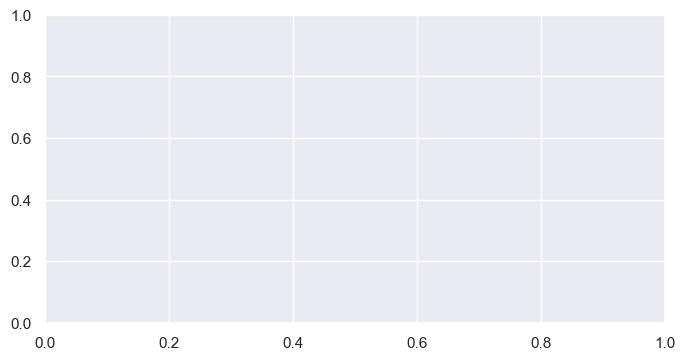

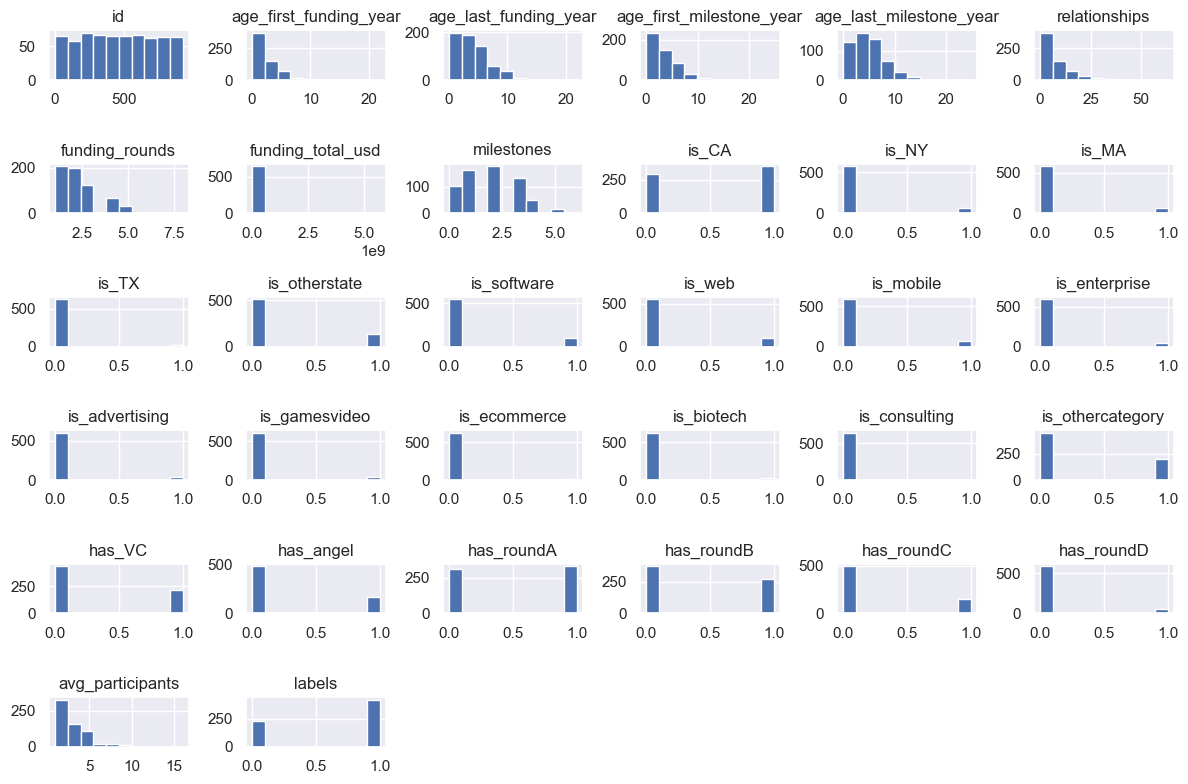

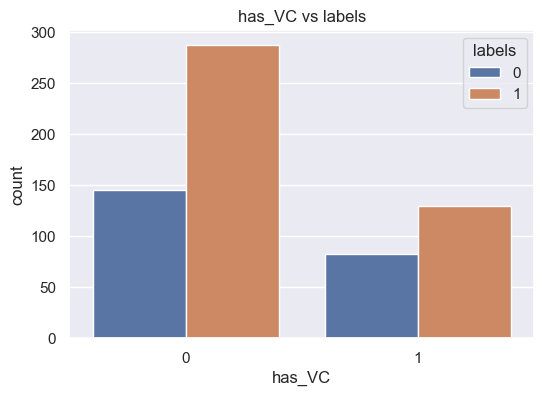

In [6]:

# Visão geral
display(train.describe(include='all').T)

# Nulos por coluna
nulls = train.isna().mean().sort_values(ascending=False)
display(nulls.head(15))

# Distribuições numéricas (amostra)
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(figsize=(8, 4))
train[num_cols].hist(ax=ax if len(num_cols)==1 else None, figsize=(12,8))
plt.tight_layout()
plt.show()

# Relação simples de algumas features com o alvo (exemplo)
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x='has_VC', hue=TARGET, data=train, ax=ax)
ax.set_title('has_VC vs labels')
plt.show()



## 5) Hipóteses (guiando a seleção de features)

1. Startups com **mais rodadas de funding** e/ou **VC** têm maior chance de sucesso.  
2. **Tempo até milestones/fundings** menor está associado a trajetórias de sucesso.  
3. **Localização e setor** impactam a taxa de sucesso (efeitos capturados por dummies e `category_code` codificado).



## 6) Pré-processamento e seleção de features

- Numéricas: imputação por **mediana** + **padronização** (`StandardScaler`) para modelos lineares.  
- Categóricas: `OneHotEncoder(handle_unknown='ignore')`.  
- **category_code** incluída no encoder (opcional: pode ser removida se preferir usar apenas dummies já prontas).


In [7]:

# Detectar colunas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Pipeline de pré-processamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

len(numeric_features), len(categorical_features), categorical_features[:5]


(31, 1, ['category_code'])


## 7) Modelos baseline

Começamos com **LogisticRegression** (com `class_weight='balanced'` como alternativa) e **RandomForestClassifier**. Métrica principal: **acurácia** no **holdout**. Apresentamos também precisão/recall/F1.


LogReg (baseline) -> Acc: 0.7154 | Prec: 0.7701 | Rec: 0.7976 | F1: 0.7836


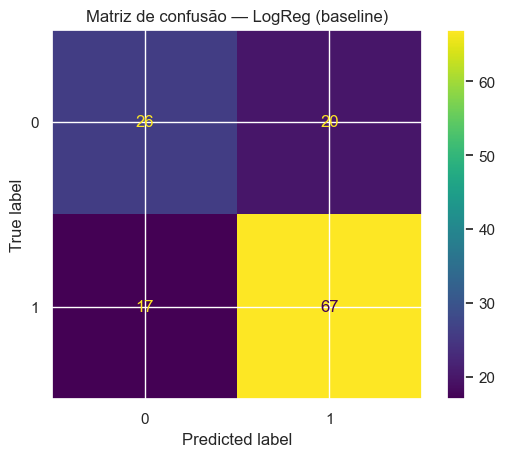

RandomForest (baseline) -> Acc: 0.7462 | Prec: 0.7629 | Rec: 0.8810 | F1: 0.8177


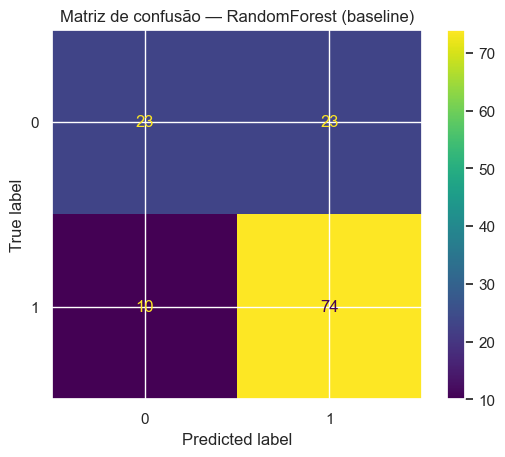

(0.7461538461538462,
 0.7628865979381443,
 0.8809523809523809,
 0.8176795580110497)

In [8]:

def evaluate(y_true, y_pred, title='Validação'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{title} -> Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(values_format='d')
    plt.title(f'Matriz de confusão — {title}')
    plt.show()
    return acc, prec, rec, f1

# Logistic Regression
logreg = Pipeline(steps=[('pre', preprocessor),
                        ('clf', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))])
logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_valid)
evaluate(y_valid, pred_lr, title='LogReg (baseline)')

# Random Forest
rf = Pipeline(steps=[('pre', preprocessor),
                    ('clf', RandomForestClassifier(
                        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
                    ))])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)
evaluate(y_valid, pred_rf, title='RandomForest (baseline)')



## 8) Tuning de hiperparâmetros (GridSearchCV)

Foco em **acurácia** com `cv=5`. Mantemos buscas enxutas para reprodutibilidade.


Best LR: {'clf__C': 3.0, 'clf__class_weight': None, 'clf__penalty': 'l2'} Acc: 0.7520351008215086
Best RF: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200} Acc: 0.7945855115758029
Escolhido: RandomForestClassifier {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Melhor modelo (validação) -> Acc: 0.7692 | Prec: 0.7935 | Rec: 0.8690 | F1: 0.8295


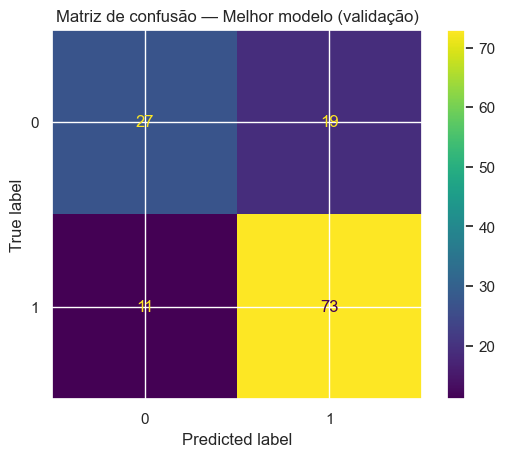

(0.7692307692307693,
 0.7934782608695652,
 0.8690476190476191,
 0.8295454545454546)

In [9]:

# Exemplo 1: LogReg
grid_lr = {
    'clf__C': [0.1, 1.0, 3.0],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced']
}
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                         ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
gs_lr = GridSearchCV(pipe_lr, grid_lr, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
gs_lr.fit(X_train, y_train)
print('Best LR:', gs_lr.best_params_, 'Acc:', gs_lr.best_score_)

# Exemplo 2: RandomForest
grid_rf = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 8, 16],
    'clf__min_samples_split': [2, 5],
}
pipe_rf = Pipeline(steps=[('pre', preprocessor),
                         ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
gs_rf.fit(X_train, y_train)
print('Best RF:', gs_rf.best_params_, 'Acc:', gs_rf.best_score_)

# Escolher o melhor entre LR e RF via validação
best_model = gs_lr if gs_lr.best_score_ >= gs_rf.best_score_ else gs_rf
print('Escolhido:', type(best_model.best_estimator_['clf']).__name__, best_model.best_params_)

pred_best = best_model.predict(X_valid)
evaluate(y_valid, pred_best, title='Melhor modelo (validação)')



## 9) Treino final e previsão no conjunto de teste


In [10]:

# Refit no conjunto de treino completo
best_model.refit = True
best_model.fit(X, y)

test_pred = best_model.predict(test)

# Conferir o sample_submission
display(sample_sub.head())

# Tentar detectar o nome da coluna de ID no sample_submission
id_cols = [c for c in sample_sub.columns if c.lower() not in ['label', 'labels', 'target']]
if len(id_cols) != 1:
    print('Atenção: não foi possível inferir uma única coluna de ID. Ajuste manualmente.')
id_col = id_cols[0] if len(id_cols) >= 1 else sample_sub.columns[0]

# Construir submissão com a coluna alvo esperada
target_col = 'labels' if 'labels' in sample_sub.columns else sample_sub.columns[-1]

submission = sample_sub.copy()
submission[target_col] = test_pred
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
submission.head()


,id,labels
0,70,0
1,23,0
2,389,0
3,872,0
4,920,0


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1



## 10) Conclusões rápidas / próximos passos

- Validar importância de variáveis (ex.: `feature_importances_` no RF ou coeficientes na LR após OHE).  
- Testar ajuste de **limiar de decisão** (especialmente se recall/precisão estiverem desequilibrados).  
- Considerar **calibração** de probabilidades e avaliação com **AUC** para análise adicional (mesmo que o ranking use acurácia).  
- Documentar trade-offs observados entre modelos.


## 11) Utils (opcional)

In [11]:

# Exemplo: função para relatório curto
def summarize_model(X_train, model):
    print(type(model.named_steps['clf']).__name__)
    # Nota: com OneHotEncoder no ColumnTransformer, a recuperação de nomes de features expandidos exige steps adicionais.
    # Este bloco fica como placeholder para expansão futura.
    return

summarize_model(X_train, best_model.best_estimator_)


RandomForestClassifier
